In [228]:
import matplotlib.pyplot as plt
import numpy as np
# import xlrd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.pyplot import MultipleLocator

import pandas as pd
import os 

import seaborn as sns
# plt.style.use('ggplot')

In [229]:
PERF_RESULT = os.getenv('PERF_RESULT', './perf_result/result.csv')
data = pd.read_csv(PERF_RESULT, sep=',').sort_values(by='model')
data['p90 latency(ms)'] = data['p90 latency'].apply(lambda x: x/1000)





In [230]:
data.head()

,model,batch_size,Concurrency,Inferences/Second,Client Send,Network+Server Send/Recv,Server Queue,Server Compute Input,Server Compute Infer,Server Compute Output,Client Recv,p50 latency,p90 latency,p95 latency,p99 latency,p90 latency(ms)
29,simple_yolov5_bls,8,10,18.4,17191,3773735,47427,1632,18529,279,6,3946549,4379851,4393542,4627539,4379.851
27,simple_yolov5_bls,8,8,20.8,9429,3053742,29319,1822,18852,197,4,3105001,3295851,3408163,3409707,3295.851
26,simple_yolov5_bls,8,7,20.0,9847,2645427,34463,1621,18132,253,3,2792957,3069375,3091151,3103712,3069.375
25,simple_yolov5_bls,8,6,20.8,9913,2325201,36690,1817,18752,209,3,2535203,2718031,2822015,2829911,2718.031
24,simple_yolov5_bls,8,5,20.0,9080,1906237,31880,1693,19254,274,4,2172222,2375632,2420122,2478506,2375.632


Text(0.5, 1.0, 'thoughput vs latency at batch size 8')

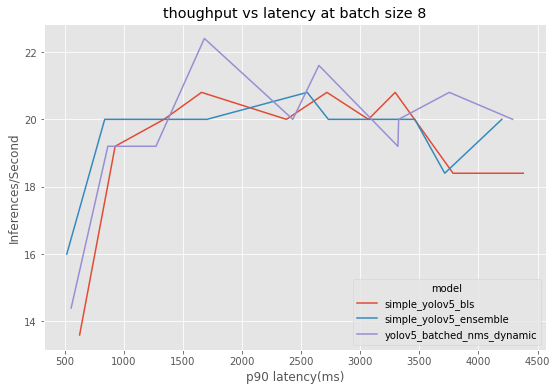

In [231]:
# models = data.model.unique()

from matplotlib.pyplot import title


fig, ax = plt.subplots(figsize=(9,6))

sns.lineplot(x='p90 latency(ms)', y='Inferences/Second', hue="model", data=data ,ax=ax).set_title('thoughput vs latency at batch size 8')


# for index, model_name in enumerate(models):
#     random_color = colors[index]

#     ax.plot(data[data.model==model_name]['p90 latency'], data[data.model==model_name]['Inferences/Second'], \
#             linewidth=1, color=random_color, alpha=0.8, label=f'{model_name}')
#     # ax.set_ylabel("T(ms)-interval")
#     ax.legend()


## metrics process

In [232]:
radar_data = data.copy()
indices_cols = ['p90 latency(ms)', 'Inferences/Second', 'Server Queue', 'Server Compute Input', 'Server Compute Infer', 'Server Compute Output']
cols = ['model', 'Concurrency'] + indices_cols
radar_data = radar_data[cols]

# sensitive to Concurrency
radar_data['Server Queue'] = radar_data['Server Queue'] / radar_data['Concurrency']
radar_data['p90 latency(ms)'] = radar_data['p90 latency(ms)'] / radar_data['Concurrency']

# reverse timestamp value to speed and min-max normalization 
for col in indices_cols:
        
    if col != 'Inferences/Second':
        radar_data[col] = 1 / radar_data[col]
    radar_data[col] = (radar_data[col] - radar_data[col].min()) / (radar_data[col].max() - radar_data[col].min())


plot_data = radar_data.groupby('model', as_index=False)[indices_cols].quantile(0.9)
plot_data = plot_data.rename(columns={
                                      'p90 latency(ms)': 'latency',
                                      'Inferences/Second': 'throughput'
                                      }
                            )
plot_cols = ['latency', 'throughput', 'Server Queue', 'Server Compute Input', 'Server Compute Infer', 'Server Compute Output']

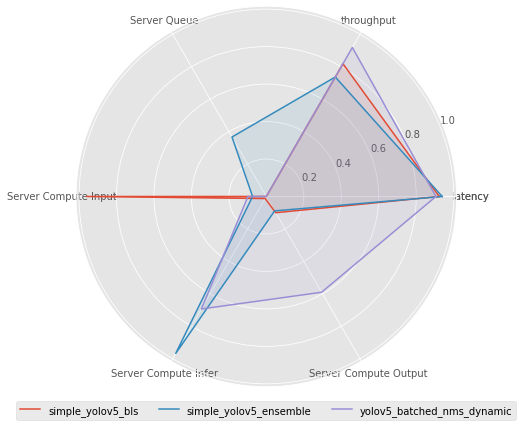

In [233]:
models = plot_data.model.unique()
plt.figure(figsize =(7, 7))
plt.subplot(polar = True) 
plot_cols.append(plot_cols[0])
theta = np.linspace(0, 2 * np.pi, len(plot_cols)) 
# thetas = np.concatenate((theta, [theta[0]]))
# print(thetas*180/np.pi)
# print(thetas)

# print(plot_cols)
lines, labels = plt.thetagrids(theta*180/np.pi,  plot_cols)
# print(lines)
for model in models:
    perf_data = plot_data[plot_data.model==model][plot_cols].values[0].tolist()
    # perf_data.append(perf_data[0])
    plt.plot(theta, perf_data)
    plt.fill(theta, perf_data, alpha = 0.1) 
# bbox_to_anchor=(1, 0.2, 0.2, 0.8)
# plt.legend(labels = models,bbox_to_anchor=(1, 0.2, 0.2, 0.8), fontsize=12) 
plt.legend(labels = models, loc = 'lower center', bbox_to_anchor=(0.5, -0.1), ncol=3,  fontsize=10) 


plt.show()